### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

In [1]:
import json

import bz2
import regex
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#%pylab inline

In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in thefile:
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

In [5]:
len(responses)

153499

In [6]:
responses_df = pd.DataFrame.from_records(responses)

In [7]:
responses_df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


### Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
bank_name = []

for i in responses:
        
    if i.get('bank_name') in bank_name:
        pass
    else:
        bank_name.append(i.get('bank_name'))
    
    

In [8]:
cities = []

for i in responses:
        
    if i.get('city') in cities:
        pass
    else:
        cities.append(i.get('city'))
    

In [9]:
print('количество отзывов в разных городах:', len(cities), ' и на разные банки:',len(bank_name))

количество отзывов в разных городах: 5824  и на разные банки: 670


2. Постройте гистограмы длин слов в символах и в словах

3. Найдите 10 самых частых:  
-слов  
-слов без стоп-слов  
-лемм  
-существительных

In [17]:
from collections import Counter
from string import punctuation
from nltk.tokenize import word_tokenize

In [11]:
corpus = [token for text in responses for token in word_tokenize(text['text']) if token not in punctuation]    

In [12]:
len(corpus)

36766257

In [11]:
freq_dict = Counter(corpus)

In [12]:
print('10 самых частых слов')
freq_dict.most_common(10)

10 самых частых слов


[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235176)]

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35846\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords

In [11]:
signs = ['``', "''", '...']

In [12]:
noise = stopwords.words('russian') + list(punctuation) + signs

In [36]:
corpus = [token for text in responses for token in word_tokenize(text['text']) if token not in noise]

In [44]:
freq_dict = Counter(corpus)

In [45]:
print('10 самых частых слов без стоп-слов')
freq_dict.most_common(10)

10 самых частых слов без стоп-слов


[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235176)]

In [46]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [55]:
lemmatized_text = [pymorphy2_analyzer.parse(word)[0].normal_form for word in corpus]

In [207]:
lemmatized_text[:10]

['добрый',
 'день',
 'являться',
 'клиент',
 'банк',
 'поручитель',
 'кредитный',
 'договор',
 'также',
 'являться']

In [210]:
freq_dict_lemm = Counter(lemmatized_text)

In [211]:
print('10 самых частых лемм')
freq_dict_lemm.most_common(10)

10 самых частых лемм


[('банк', 624274),
 ('карта', 331816),
 ('это', 200083),
 ('деньга', 178338),
 ('мой', 173674),
 ('день', 172636),
 ('кредит', 154865),
 ('который', 148990),
 ('отделение', 143616),
 ('счёт', 140510)]

4. Постройте кривые Ципфа и Хипса

Закон Ципфа.  
Эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

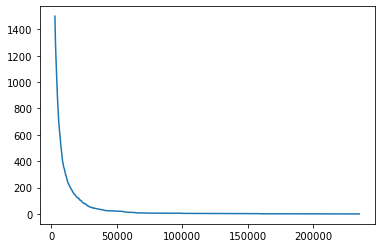

In [87]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:1500], range(1500))
plt.show()

Закон Хипса  
С увеличением длины текста (количества токенов), количество слов увеличивается в соответствии с законом:  |V|=K∗Nb

In [22]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for row in responses_df.text:
    tokens = word_tokenize(row)
    cnt.update([token for token in tokens if token not in noise])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

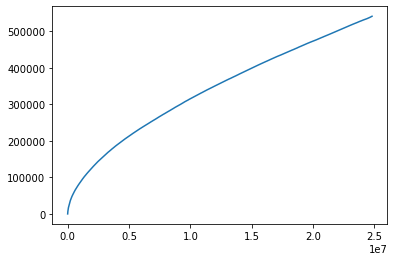

In [23]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

5. Ответьте на следующие вопросы:  
-какое слово встречается чаще, "сотрудник" или "клиент"?  
-сколько раз встречается слова "мошенничество" и "доверие"?

In [229]:
sotr = 0
klient = 0
moc = 0
dov = 0
for i in lemmatized_text:
    if i=='сотрудник':
        sotr=sotr+1
    elif i=='клиент':
        klient=klient+1
    elif i=='мошенничество':
        moc=moc+1
    elif i=='доверие':
        dov=dov+1
    else:
        continue
        
    
    

In [230]:
if sotr < klient:
    print('слово клиент встречается чаще, чем слово сотрудник')
else:
    print('слово сотрудник встречается чаще, чем слово клиент')

слово сотрудник встречается чаще, чем слово клиент


In [233]:
print('слово мошенничество встречается', moc, 'раз')

слово мошенничество встречается 3228 раз


In [234]:
print('слово доверие встречается', dov, 'раз')

слово доверие встречается 2098 раз


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [47]:
import gensim

In [48]:
def preprocess(input_text):
        
    text = input_text.lower()
    tokenized_text = word_tokenize(text)
    clean_text = [word for word in tokenized_text if word not in noise]
    lemmatized_text = [pymorphy2_analyzer.parse(word)[0].normal_form for word in 
                       clean_text]
    
    return lemmatized_text

In [49]:
responses_df["text_processed"] = responses_df["text"].map(preprocess)

In [51]:
responses_df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_processed
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[добрый, день, являться, клиент, банк, поручит..."
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[добрый, день, являться, держатель, зарплатный..."
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[здравствуйте, дублировать, свой, заявление, 0..."


In [62]:
gensim_dictionary = gensim.corpora.Dictionary(responses_df["text_processed"])
#gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
#gensim_dictionary.compactify()

In [63]:
corpus = [gensim_dictionary.doc2bow(text) for text in responses_df['text_processed']]

In [67]:
lda_20 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=20, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=42)

In [68]:
lda_20.print_topics()

[(0,
  '0.027*"банк" + 0.027*"заявка" + 0.023*"день" + 0.013*"позвонить" + 0.012*"сказать" + 0.009*"кредит" + 0.009*"документ" + 0.008*"звонить" + 0.008*"анкета" + 0.008*"неделя"'),
 (1,
  '0.039*"карта" + 0.016*"банк" + 0.014*"отделение" + 0.012*"вопрос" + 0.010*"оператор" + 0.009*"сотрудник" + 0.009*"мочь" + 0.009*"ответ" + 0.009*"телефон" + 0.008*"номер"'),
 (2,
  '0.032*"документ" + 0.023*"банк" + 0.014*"справка" + 0.011*"мы" + 0.010*"квартира" + 0.009*"сделка" + 0.008*"ипотека" + 0.008*"который" + 0.007*"паспорт" + 0.007*"ипотечный"'),
 (3,
  '0.034*"деньга" + 0.028*"банк" + 0.022*"банкомат" + 0.019*"сумма" + 0.019*"счёт" + 0.017*"операция" + 0.015*"перевод" + 0.014*"средство" + 0.014*"рубль" + 0.012*"карта"'),
 (4,
  '0.066*"кредит" + 0.027*"банк" + 0.018*"сумма" + 0.014*"страховка" + 0.013*"договор" + 0.011*"это" + 0.008*"сказать" + 0.008*"кредитный" + 0.008*"год" + 0.008*"страхование"'),
 (5,
  '0.035*"платёж" + 0.027*"банк" + 0.017*"сумма" + 0.012*"кредит" + 0.012*"день" + 0.0

1. Подача заявки на кредит
2. Оформление карт
3. Денежные операции
4. Страхование кредитов
5. Оплата кредитов
6. ....
7. Вклады
8. ....
9. Обслуживание клиентов
10. Мобильное приложение

In [64]:
lda_10 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=10, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=42)

In [65]:
lda_10.print_topics()

[(0,
  '0.034*"банк" + 0.016*"звонить" + 0.016*"звонок" + 0.015*"телефон" + 0.014*"номер" + 0.013*"ваш" + 0.011*"это" + 0.011*"сотрудник" + 0.011*"мой" + 0.010*"кредит"'),
 (1,
  '0.066*"карта" + 0.018*"банк" + 0.010*"это" + 0.008*"отделение" + 0.007*"день" + 0.007*"сказать" + 0.006*"получить" + 0.006*"который" + 0.006*"мой" + 0.006*"мочь"'),
 (2,
  '0.026*"банк" + 0.025*"документ" + 0.015*"день" + 0.015*"заявка" + 0.008*"кредит" + 0.008*"справка" + 0.008*"сказать" + 0.007*"сотрудник" + 0.006*"менеджер" + 0.006*"который"'),
 (3,
  '0.034*"деньга" + 0.021*"банкомат" + 0.021*"банк" + 0.018*"карта" + 0.017*"счёт" + 0.012*"операция" + 0.012*"сумма" + 0.012*"день" + 0.011*"средство" + 0.009*"рубль"'),
 (4,
  '0.059*"кредит" + 0.029*"банк" + 0.016*"сумма" + 0.012*"страховка" + 0.011*"договор" + 0.010*"это" + 0.009*"кредитный" + 0.008*"сказать" + 0.007*"год" + 0.007*"000"'),
 (5,
  '0.031*"банк" + 0.019*"платёж" + 0.013*"счёт" + 0.012*"сумма" + 0.012*"день" + 0.011*"кредит" + 0.010*"деньга" +

In [66]:
lda_5 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=5, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=42)

lda_5.print_topics()

[(0,
  '0.033*"банк" + 0.013*"мой" + 0.011*"сотрудник" + 0.010*"звонок" + 0.010*"телефон" + 0.010*"звонить" + 0.010*"номер" + 0.009*"ваш" + 0.008*"день" + 0.008*"это"'),
 (1,
  '0.048*"карта" + 0.021*"банк" + 0.010*"это" + 0.007*"отделение" + 0.007*"день" + 0.006*"сказать" + 0.006*"который" + 0.006*"счёт" + 0.006*"мой" + 0.005*"мочь"'),
 (2,
  '0.026*"банк" + 0.010*"это" + 0.010*"вклад" + 0.010*"отделение" + 0.009*"клиент" + 0.006*"деньга" + 0.006*"офис" + 0.006*"очередь" + 0.006*"работать" + 0.006*"который"'),
 (3,
  '0.024*"банк" + 0.022*"деньга" + 0.017*"счёт" + 0.012*"карта" + 0.011*"банкомат" + 0.011*"средство" + 0.011*"мой" + 0.011*"день" + 0.010*"заявление" + 0.010*"сумма"'),
 (4,
  '0.035*"кредит" + 0.032*"банк" + 0.015*"сумма" + 0.012*"договор" + 0.012*"платёж" + 0.011*"кредитный" + 0.009*"год" + 0.008*"это" + 0.008*"день" + 0.007*"месяц"')]

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline



In [39]:
classification = responses_df[(responses_df['rating_grade']==1)|(responses_df['rating_grade']==5)]

In [40]:
classification.head(2)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0


In [41]:
classification = classification[['text', 'rating_grade']]

In [43]:
x_train, x_test, y_train, y_test = train_test_split(classification.text, classification.rating_grade, test_size=0.33)

In [58]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

In [59]:
list(vec.vocabulary_.items())[:20]

[('задержали', 62435),
 ('платеж', 120866),
 ('на', 90174),
 ('один', 106641),
 ('день', 53757),
 ('это', 185735),
 ('был', 37516),
 ('наш', 94650),
 ('девятый', 53108),
 ('сумма', 165362),
 ('была', 37517),
 ('50т', 11293),
 ('год', 50119),
 ('платили', 120940),
 ('большими', 36087),
 ('платежами', 120869),
 ('попросили', 128782),
 ('кассира', 74486),
 ('учесть', 177019),
 ('разницу', 145370)]

In [60]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [61]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98     15783
         5.0       0.91      0.94      0.93      4710

    accuracy                           0.97     20493
   macro avg       0.95      0.96      0.95     20493
weighted avg       0.97      0.97      0.97     20493



In [62]:
f1_score(pred, y_test)

0.9774804905239688

In [63]:
accuracy_score(pred, y_test)

0.9655004147757771

триграммы

In [35]:
from nltk import ngrams

In [36]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.87      0.93     17898
         5.0       0.51      0.96      0.67      2595

    accuracy                           0.88     20493
   macro avg       0.75      0.91      0.80     20493
weighted avg       0.93      0.88      0.89     20493



In [101]:
f1_score(pred, y_test)

0.9266863923010251

In [102]:
accuracy_score(pred, y_test)

0.880300590445518

3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [134]:
vectors = TfidfVectorizer().fit_transform(classification.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [135]:
X_reduced

array([[ 0.24283488,  0.01732968, -0.07200819, -0.05383434, -0.00238898],
       [ 0.25108347, -0.03584885,  0.10456853,  0.10236993,  0.0119583 ],
       [ 0.18515298, -0.05051991,  0.04033646, -0.06567233, -0.01873354],
       ...,
       [ 0.18605117, -0.00564479,  0.02518627, -0.01517126,  0.02213666],
       [ 0.17043397, -0.01833799,  0.08039265, -0.0004457 , -0.01750183],
       [ 0.11688444, -0.05769907, -0.03095766, -0.01145335,  0.02149463]])

In [136]:
x_train, x_test, y_train, y_test = train_test_split(X_reduced, classification.rating_grade, test_size=0.33)

In [137]:
clf_tsvd = LogisticRegression(random_state=42, solver='liblinear')
clf_tsvd.fit(x_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [138]:
pred = clf_tsvd.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.95      0.89      0.92     16633
         5.0       0.64      0.81      0.72      3860

    accuracy                           0.88     20493
   macro avg       0.80      0.85      0.82     20493
weighted avg       0.89      0.88      0.88     20493



In [139]:
f1_score(pred, y_test)

0.922804730421827

In [109]:
accuracy_score(pred, y_test)

0.8818133021031572

In [ ]:
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(1, 1))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])

In [160]:
from sklearn.decomposition import LatentDirichletAllocation

In [161]:
lda = LatentDirichletAllocation(n_components=5, random_state=117)

In [162]:
X_LDA = lda.fit_transform(vectors)

In [163]:
x_train, x_test, y_train, y_test = train_test_split(X_LDA, classification.rating_grade, test_size=0.33)

In [164]:
clf_lda = LogisticRegression(random_state=42, solver='liblinear')
clf_lda.fit(x_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [165]:
pred = clf_tsvd.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       1.00      0.76      0.87     20493
         5.0       0.00      0.00      0.00         0

    accuracy                           0.76     20493
   macro avg       0.50      0.38      0.43     20493
weighted avg       1.00      0.76      0.87     20493



C:\Users\35846\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
f1_score(pred, y_test)

0.8659103486441615

In [167]:
accuracy_score(pred, y_test)

0.7635290099058215

TfIdf и TruncSVD получают лучшие значения f1_score = 0,92 и accuracy=0,88